# Q2


## section 2.0: Imports

In [15]:
import numpy as np
import re
import matplotlib.pyplot as plt
import cv2
import copy
import pandas

## Section 2.1: Function to convert the txt file to an image.
in this section the txt file gets converted into an image.
it can be achieved by:
    1. first we read the file.
    2. then the first line get seperated and split into 3 parts; width,height,target_starts
    3. after that each line get strip and split then we can extract the numbers from the strings(with the use of regex).
    4. each number describes either R,G or B in a pixel, so we can construct the pixel by appending them into a list.
    5. we get the pixels and construct the rows in the image by appending the pixels.
    6. we append all the rows into a list and get the image.
    7. finally we convert the 3d list into numpy array.

In [16]:
def read_image_from_file(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    width, height, target_stars = map(int, lines[0].split())
    image_list = []
    single_pixel = []


    for line in lines[1:]:
        values = map(int, re.findall(r"\d+", line))
        single_pixel.extend(values)
        while len(single_pixel) >= 3:
            image_list.append(single_pixel[:3])
            single_pixel = single_pixel[3:]

    # Convert the list of pixel values to a NumPy array and reshape it
    return np.uint8(np.array(image_list).reshape(width,height, 3))


## Section 2.2: a function to visualize an image.
in this section we can visualize an image using the matplotlib library.


In [17]:
def visualize_image(image_to_show,title,cmap=None):
    plt.imshow(image_to_show,cmap=cmap)
    plt.title(title)
    plt.axis('off')

    plt.show()

## Section 2.3: a function to visualize two images side by side.

In [18]:
def show_images_side_by_side(image1,image2,title1="image1",title2="image2"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(image2)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Section 2.4: a function to check if the image needs sharpening.
in this section we the Laplacian kernel to check if the image needs sharpening ( it detects if the edges are blured)
if it is blured we use a convolution with a certain kernel to sharpen the image.


In [19]:
def get_sharpened_image(image_to_sharpen):
    gray = cv2.cvtColor(image_to_sharpen, cv2.COLOR_BGR2GRAY)
    if cv2.Laplacian(gray, cv2.CV_64F).var() >10000:
        return image_to_sharpen
    else :
        kernel = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])


        return cv2.filter2D(image_to_sharpen, -1, kernel)

## Section 2.5.1: get the image and show it.(original)

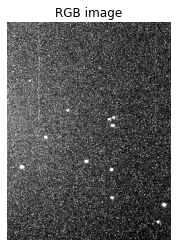

In [20]:
original_image_without_sharpening = read_image_from_file('input1.txt')
visualize_image(original_image_without_sharpening, "RGB image")




## Section 2.5.2: get the image and show it.(sharpened)

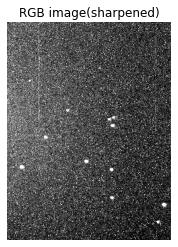

In [21]:
image = get_sharpened_image(read_image_from_file('input1.txt'))
visualize_image(image,"RGB image(sharpened)")

## Section 2.6: convert the image to a grayscale image
the most important feature of the image for us is the brightness.
so we convert into an HSV picture and extract the brightness channel.

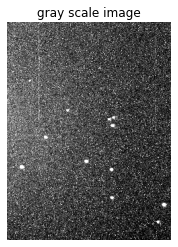

In [22]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
brightness_channel = hsv_image[:, :, 2] # Extract the brightness channel from the HSV image
gray_image = brightness_channel
visualize_image(gray_image,title="gray scale image", cmap='gray')

## Section 2.7 : brute force approach.
in this method we identify the stars by converting the image into binary then we find all clusters of bright pixels.

### Section 2.7.1 : convert the image to binary.


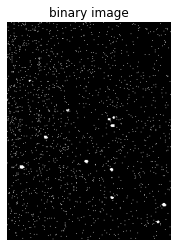

In [23]:
ret, binary_image = cv2.threshold(gray_image, 210, 255, cv2.THRESH_BINARY)
visualize_image(binary_image,title="binary image", cmap='binary_r')

### Section 2.7.2 : a function to find the adjacent bright stars , count them and if there are more than 5 of those we count it as a star and add the center coordinates in a dataframe.

In [24]:
def get_the_star(x, y, binary_image_copy, image_copy,stars):
    bright_pixels_list = [[x, y]]
    to_color_set = {(x, y)}  # Use a set to keep track of unique coordinates
    num_of_bright_pixels = 1
    leftmost_pixel , rightmost_pixel , topmost_pixel , botmost_pixel = y,y,x,x
    while bright_pixels_list:
        bright_pixel_x_coordinate, bright_pixel_y_coordinate = bright_pixels_list.pop(0)
        if binary_image_copy[bright_pixel_x_coordinate, bright_pixel_y_coordinate] != 0:
            binary_image_copy[bright_pixel_x_coordinate, bright_pixel_y_coordinate] = 0
            num_of_bright_pixels += 1

            neighbors = [
                (bright_pixel_x_coordinate + 1, bright_pixel_y_coordinate),
                (bright_pixel_x_coordinate - 1, bright_pixel_y_coordinate),
                (bright_pixel_x_coordinate, bright_pixel_y_coordinate + 1),
                (bright_pixel_x_coordinate, bright_pixel_y_coordinate - 1)
            ]

            for neighbor in neighbors:
                nx, ny = neighbor
                if nx < len(binary_image_copy) and ny < len(binary_image_copy[0]):
                    if (
                        len(binary_image_copy) > nx >= 0 != binary_image_copy[nx, ny] and
                        0 <= ny < len(binary_image_copy[0]) and
                        (nx, ny) not in to_color_set
                    ):
                        topmost_pixel = max(topmost_pixel, nx)
                        botmost_pixel = min(botmost_pixel, nx)
                        rightmost_pixel = max(rightmost_pixel, ny)
                        leftmost_pixel = min(leftmost_pixel, ny)
                        bright_pixels_list.append([nx, ny])
                        to_color_set.add((nx, ny))

    if num_of_bright_pixels >= 8:
        stars['size(pixels)'].append(len(to_color_set))
        stars['center'].append(((int((topmost_pixel + botmost_pixel)/2)),int((rightmost_pixel + leftmost_pixel)/2)))
        for x, y in to_color_set:
            image_copy[x, y] = (255, 255, 0)
        image_copy[(int((topmost_pixel + botmost_pixel)/2)), int((rightmost_pixel + leftmost_pixel)/2)] = (255, 0, 0)
        return True

    return False


### Section 2.7.3 : iterate the image. once we get a bright pixel we check if it is part of a star then we plot the image.

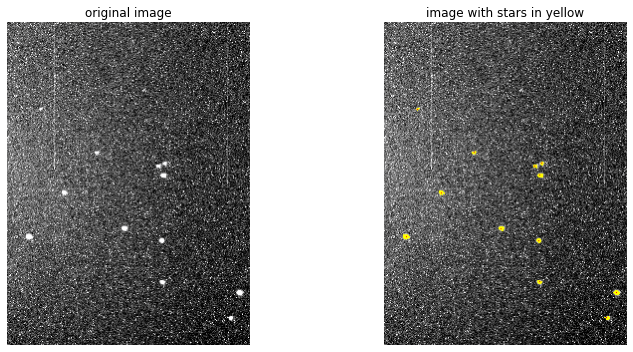

In [25]:
binary_image_copy = copy.deepcopy(binary_image)
image_copy = copy.deepcopy(image)
stars = {
    'size(pixels)': [],
    'center': [],
}
for x in range(len(binary_image_copy)):
    for y in range(len(binary_image_copy[x])):
        if binary_image_copy[x,y] != 0 :
            get_the_star(x, y, binary_image_copy=binary_image_copy, image_copy=image_copy,stars=stars)

show_images_side_by_side(original_image_without_sharpening,image_copy,title1="original image",title2="image with stars in yellow")


### Section 2.7.4 : we store all the data in a pandas dataframe.

In [26]:
df = pandas.DataFrame(stars)
df

,size(pixels),center
0,7,"(87, 33)"
1,12,"(130, 90)"
2,11,"(141, 158)"
3,13,"(144, 151)"
4,22,"(153, 156)"
5,21,"(171, 57)"
6,22,"(207, 117)"
7,29,"(215, 22)"
8,19,"(219, 155)"
9,16,"(260, 156)"


### Section 2.7.5 : output.

In [27]:
print(len(df))
column_values = df["center"].values
for value in column_values:
    print(f"{value[0]} {value[1]} ")

12
87 33 
130 90 
141 158 
144 151 
153 156 
171 57 
207 117 
215 22 
219 155 
260 156 
271 233 
296 223 
